# Modelling Bennu with mascons

From blender we import the asteroid model, decimate it and run the following script in the python scripting window of a Windows installation of blender 2.82. 

```python 
import pickle as pk
mesh = C.selected_objects[0].data
polygons = mesh.polygons
vertices = mesh.vertices
loops = mesh.loops
points = [[v.co.x, v.co.y, v.co.z] for v in vertices]
triangles = [[loops[id].vertex_index for id in range(poly.loop_start, poly.loop_start + poly.loop_total)] for poly  in polygons] 
with open(r"C:\Users\Dario Izzo\Desktop\Bennu_raw_lp.pk", "wb") as file:
    pk.dump((points, triangles), file)
```

Its important that the above script is run in the blender python only after the asetroid has been selected.

The algorithms to deal with the 3D mesh are those containied in tetgen and pyvista. In your conda environment,
install those via pip:
```bash
pip install tetgen
```
The above line should take care of both

In [1]:
# core stuff
import pickle as pk
import numpy as np

# meshing
import pyvista as pv
import tetgen

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

#misc
import sobol_seq
from scipy import spatial

## Importing the 2D mesh
We open the file we pickled and read the mesh we exported from blender and that was normalized to have a maximum of .9 and the center of mass in the origin.

In [2]:
with open("../3dmeshes/Bennu_raw.pk", "rb") as f:
    mesh_points, mesh_triangles = pk.load(f)
mesh_points = np.array(mesh_points) 
mesh_triangles = np.array(mesh_triangles)
with open("../3dmeshes/Bennu_raw_lp.pk", "rb") as f:
    mesh_points_lp, mesh_triangles_lp = pk.load(f)
mesh_points_lp = np.array(mesh_points_lp)
# Characteristic dimension
L = max(mesh_points[:,0]) - min(mesh_points[:,0])

In [3]:
print("............................................................")
print("Number of triangles for Bennu: ", len(mesh_triangles))
print("Number of points for Bennu: ", len(mesh_points))
print("Physical dimension along x: ", max(mesh_points[:,0]) - min(mesh_points[:,0]), "Km")
print("............................................................")
print("Number of triangles for Bennu: ", len(mesh_triangles_lp))
print("Number of points for Bennu (Low Precision): ", len(mesh_points_lp))
print("Physical dimension along x (Low Precision): ", max(mesh_points_lp[:,0]) - min(mesh_points_lp[:,0]), "Km")
print("............................................................")


............................................................
Number of triangles for Bennu:  14744
Number of points for Bennu:  7374
Physical dimension along x:  0.5634379088878632 Km
............................................................
Number of triangles for Bennu:  1474
Number of points for Bennu (Low Precision):  739
Physical dimension along x (Low Precision):  0.5625173449516296 Km
............................................................


In [4]:
# Non dimensional units
mesh_points = mesh_points / L * 2 * 0.8
mesh_points_lp = mesh_points_lp / L * 2 * 0.8
print("Units: ", L/2./0.8, " Km")

Units:  0.3521486930549145  Km


<IPython.core.display.Javascript object>


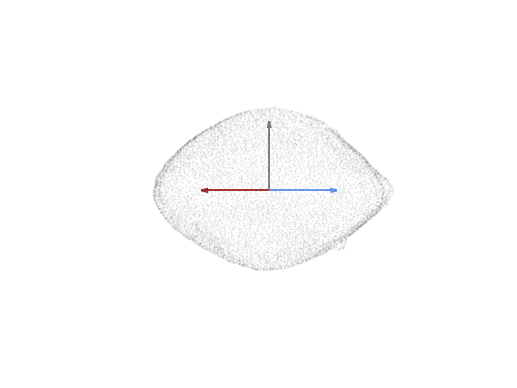

In [5]:
# Visualizing the vertices
D = 0.6
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mesh_points[:,0], mesh_points[:,1], mesh_points[:,2], alpha=0.05, s=0.5, c='k')
ax.view_init(elev=0., azim=45.)
ax.set_xlim([-D,D])
ax.set_ylim([-D,D])
ax.set_zlim([-D,D])
ax.set_axis_off()
ax.quiver(0, 0, 0, 0, 0, 1, length=0.6, normalize=True, arrow_length_ratio=0.1, color='gray')
ax.quiver(0, 0, 0, 0, 1, 0, length=0.6, normalize=True, arrow_length_ratio=0.1, color='cornflowerblue')
ax.quiver(0, 0, 0, 1, 0, 0, length=0.6, normalize=True, arrow_length_ratio=0.1, color='brown')

## Generating a 3D thetraedrical grid

In [6]:
# Here we define the surface
tgen = tetgen.TetGen(mesh_points, mesh_triangles)
# Here we run the algorithm to mesh the inside with thetrahedrons
nodes, elems = tgen.tetrahedralize()

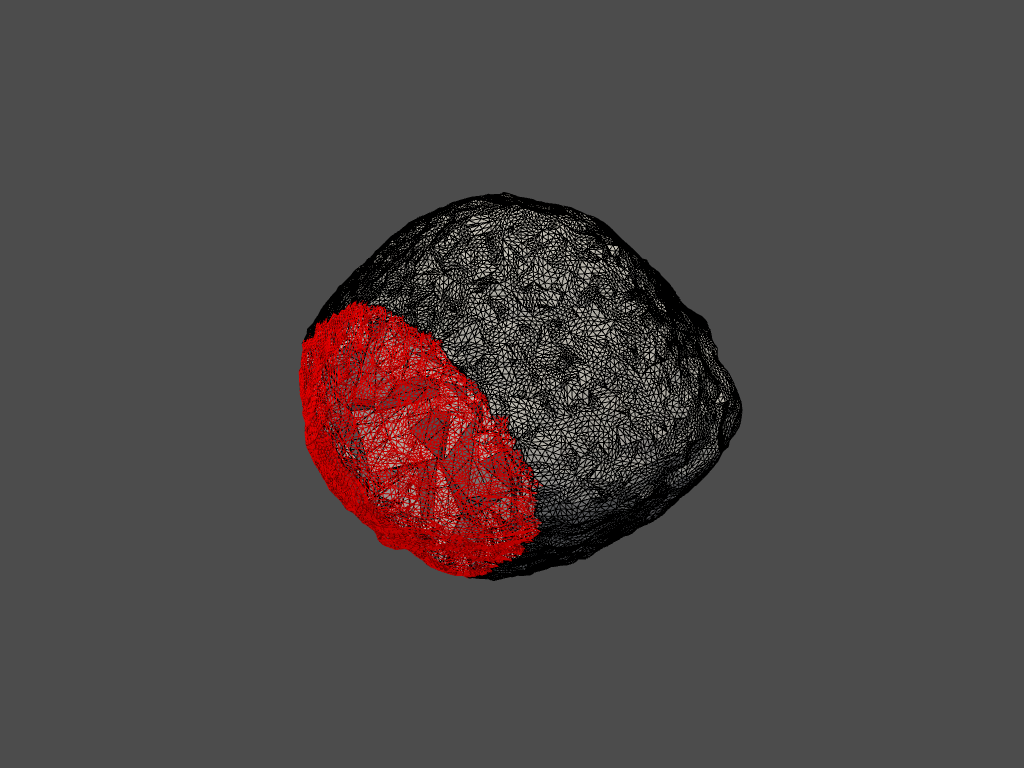

In [7]:
# get all cell centroids
grid = tgen.grid
cell_center = grid.cell_centers().points

# extract cells below the 0 xy plane
mask = cell_center[:, 0] < 0.45
cell_ind = mask.nonzero()[0]
subgrid = grid.extract_cells(cell_ind)

# advanced plotting
plotter = pv.Plotter()
plotter.add_mesh(subgrid, 'lightgrey', lighting=True, show_edges=True)
plotter.add_mesh(grid, 'r', 'wireframe')
plotter.show()

In [8]:
grid = grid.compute_cell_sizes(volume=True, area=False, length=False)

In [9]:
mascon_points = np.array(grid.cell_centers().points)
mascon_masses = grid["Volume"]
mascon_masses = mascon_masses/sum(mascon_masses)
print("Number of resulting mascons: ", len(mascon_points))

Number of resulting mascons:  37799


<IPython.core.display.Javascript object>


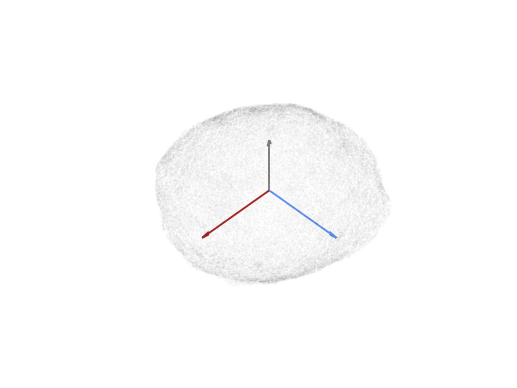

In [10]:
# Visualizing the mascon model
D = 0.6
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mascon_points[:,0], mascon_points[:,1], mascon_points[:,2], alpha=0.01, s=0.5, c='k')
ax.view_init(elev=45., azim=45.)
ax.set_xlim([-D,D])
ax.set_ylim([-D,D])
ax.set_zlim([-D,D])
ax.set_axis_off()
ax.quiver(0, 0, 0, 0, 0, 1, length=0.6, normalize=True, arrow_length_ratio=0.1, color='gray')
ax.quiver(0, 0, 0, 0, 1, 0, length=0.6, normalize=True, arrow_length_ratio=0.1, color='cornflowerblue')
ax.quiver(0, 0, 0, 1, 0, 0, length=0.6, normalize=True, arrow_length_ratio=0.1, color='brown')

## Putting the model in a frame made of principal axis of inertia

In [11]:
# COM (for meshes too)
offset = np.sum(mascon_points*mascon_masses.reshape((-1,1)), axis=0) / np.sum(mascon_masses)
mascon_points = mascon_points - offset
mesh_points = mesh_points - offset
mesh_points_lp = mesh_points_lp - offset

In [12]:
# Principal axis
I = np.matrix('0.,0.,0.;0.,0.,0.;0.,0.,0.')
I[0,0] = sum((mascon_points[:,1]*mascon_points[:,1] + mascon_points[:,2]*mascon_points[:,2]) * mascon_masses)
I[1,1] = sum((mascon_points[:,0]*mascon_points[:,0] + mascon_points[:,2]*mascon_points[:,2]) * mascon_masses)
I[2,2] = sum((mascon_points[:,0]*mascon_points[:,0] + mascon_points[:,1]*mascon_points[:,1]) * mascon_masses)
I[0,1] = -sum(mascon_points[:,0]*mascon_points[:,1]* mascon_masses)
I[1,0] = I[0,1]
I[0,2] = -sum(mascon_points[:,0]*mascon_points[:,2]* mascon_masses)
I[2,0] = I[0,2]
I[1,2] = -sum(mascon_points[:,1]*mascon_points[:,2]* mascon_masses)
I[2,1] = I[1,2]
LAM, R = np.linalg.eig(I)
R2 = np.matrix(R)
print(LAM)

[0.18187779 0.18825539 0.21369085]


In [13]:
# Rotate the mascon but also the meshes
mascon_points = np.array(mascon_points*R2)
mesh_points =  np.array(mesh_points*R2)
mesh_points_lp =  np.array(mesh_points_lp*R2)
# No need to swap axis as z is the maximum inertia axis.
# And we rotate 180 around z as to uniform the axis to convention
mascon_points[:,0] = -mascon_points[:,0]
mascon_points[:,1] = mascon_points[:,1]
mesh_points[:,0] = -mesh_points[:,0]
mesh_points[:,1] = mesh_points[:,1]
mesh_points_lp[:,0] = -mesh_points_lp[:,0]
mesh_points_lp[:,1] = mesh_points_lp[:,1]

<IPython.core.display.Javascript object>


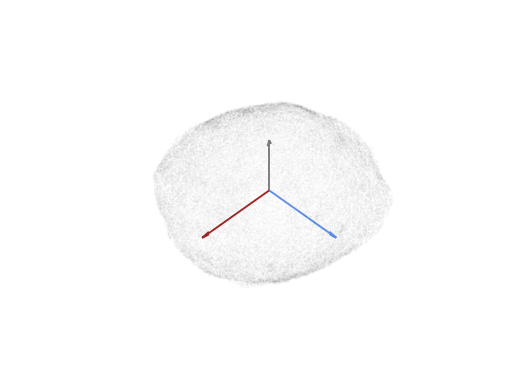

In [14]:
# Visualizing the rotated, final mascon model
D = 0.6
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mascon_points[:,0], mascon_points[:,1], mascon_points[:,2], alpha=0.01, s=0.5, c='k')
ax.view_init(elev=45., azim=45.)
ax.set_xlim([-D,D])
ax.set_ylim([-D,D])
ax.set_zlim([-D,D])
ax.set_axis_off()
ax.quiver(0, 0, 0, 0, 0, 1, length=0.6, normalize=True, arrow_length_ratio=0.1, color='gray')
ax.quiver(0, 0, 0, 0, 1, 0, length=0.6, normalize=True, arrow_length_ratio=0.1, color='cornflowerblue')
ax.quiver(0, 0, 0, 1, 0, 0, length=0.6, normalize=True, arrow_length_ratio=0.1, color='brown')

### Saving all files


In [15]:
with open("../mascons/Bennu.pk", "wb") as file:
    pk.dump((mascon_points, mascon_masses, "Itokawa"), file)
with open("../3dmeshes/Bennu.pk", "wb") as file:
    pk.dump((mesh_points.tolist(), mesh_triangles), file)
with open("../3dmeshes/Bennu_lp.pk", "wb") as file:
    pk.dump((mesh_points_lp.tolist(), mesh_triangles_lp), file)

## Building a non-uniform density mascon model

In [16]:
mascon_points_nu = np.array(grid.cell_centers().points)
mascon_masses_nu = grid["Volume"]
mascon_masses_nu = mascon_masses_nu/sum(mascon_masses_nu)
print("Number of resulting mascons: ", len(mascon_points_nu))

Number of resulting mascons:  37799


<IPython.core.display.Javascript object>


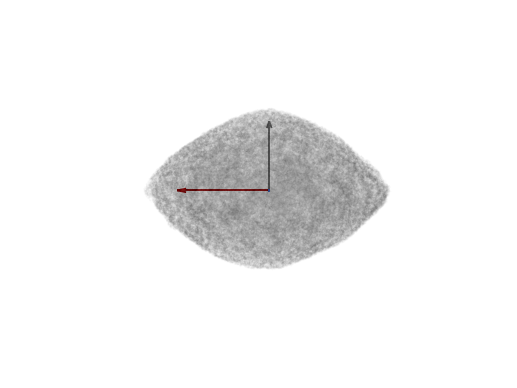

In [17]:
# Visualizing the mascon model
D = 0.6
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mascon_points_nu[:,0], mascon_points_nu[:,1], mascon_points_nu[:,2], alpha=0.01, s=mascon_masses_nu/max(mascon_masses_nu)*2000, c='k')
ax.view_init(elev=0., azim=90.)
ax.set_xlim([-D,D])
ax.set_ylim([-D,D])
ax.set_zlim([-D,D])
ax.set_axis_off()
ax.quiver(0, 0, 0, 0, 0, 1, length=0.6, normalize=True, arrow_length_ratio=0.1, color='gray')
ax.quiver(0, 0, 0, 0, 1, 0, length=0.6, normalize=True, arrow_length_ratio=0.1, color='cornflowerblue')
ax.quiver(0, 0, 0, 1, 0, 0, length=0.6, normalize=True, arrow_length_ratio=0.1, color='brown')

In [18]:
mask = np.logical_or(mascon_points_nu[:,2] > 0.2,  mascon_points_nu[:,2] < -0.2)
mascon_masses_nu[mask] = mascon_masses_nu[mask] * 1.2
mascon_masses_nu = mascon_masses_nu / sum(mascon_masses_nu)

<IPython.core.display.Javascript object>


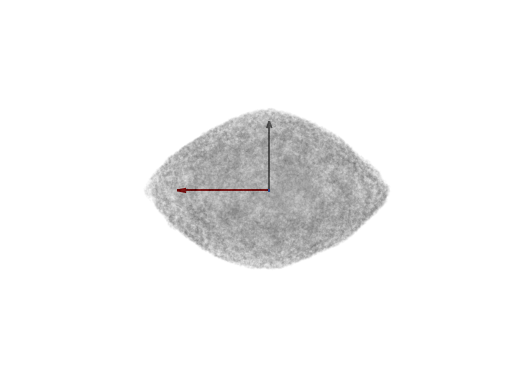

In [19]:
# Visualizing the mascon model
D = 0.6
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mascon_points_nu[:,0], mascon_points_nu[:,1], mascon_points_nu[:,2], alpha=0.01, s=mascon_masses_nu/max(mascon_masses_nu)*2000, c='k')
ax.view_init(elev=0., azim=90.)
ax.set_xlim([-D,D])
ax.set_ylim([-D,D])
ax.set_zlim([-D,D])
ax.set_axis_off()
ax.quiver(0, 0, 0, 0, 0, 1, length=0.6, normalize=True, arrow_length_ratio=0.1, color='gray')
ax.quiver(0, 0, 0, 0, 1, 0, length=0.6, normalize=True, arrow_length_ratio=0.1, color='cornflowerblue')
ax.quiver(0, 0, 0, 1, 0, 0, length=0.6, normalize=True, arrow_length_ratio=0.1, color='brown')

In [20]:
with open("../mascons/Bennu_nu.pk", "wb") as file:
    pk.dump((mascon_points_nu, mascon_masses_nu, "Bennu non-uniform"), file)

... exaggerating

In [21]:
mascon_masses_nu_e = mascon_masses_nu.copy()
mascon_masses_nu_e[mask] = mascon_masses_nu_e[mask] / 1.2 * 10.
mascon_masses_nu_e = mascon_masses_nu_e / sum(mascon_masses_nu_e)

<IPython.core.display.Javascript object>


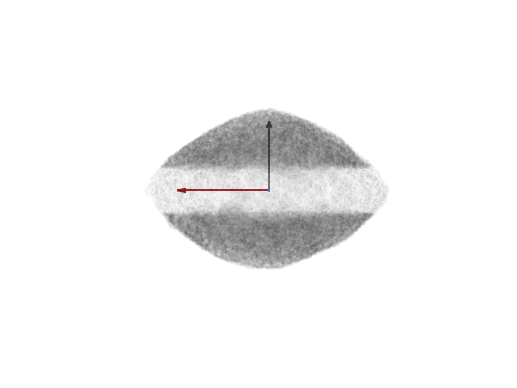

In [22]:
# Visualizing the mascon model
D = 0.6
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mascon_points_nu[:,0], mascon_points_nu[:,1], mascon_points_nu[:,2], alpha=0.01, s=mascon_masses_nu_e/max(mascon_masses_nu)*2000, c='k')
ax.view_init(elev=0., azim=90.)
ax.set_xlim([-D,D])
ax.set_ylim([-D,D])
ax.set_zlim([-D,D])
ax.set_axis_off()
ax.quiver(0, 0, 0, 0, 0, 1, length=0.6, normalize=True, arrow_length_ratio=0.1, color='gray')
ax.quiver(0, 0, 0, 0, 1, 0, length=0.6, normalize=True, arrow_length_ratio=0.1, color='cornflowerblue')
ax.quiver(0, 0, 0, 1, 0, 0, length=0.6, normalize=True, arrow_length_ratio=0.1, color='brown')

In [23]:
with open("../mascons/Bennu_nu_e.pk", "wb") as file:
    pk.dump((mascon_points_nu, mascon_masses_nu_e, "Bennu non-uniform exaggerated"), file)